# Stateful Computations in JAX

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb)

*Authors: Vladimir Mikulik*

This section explores how JAX constrains the implementation of stateful programs.

## Motivation

In machine learning, program state most often comes in the form of:
* model parameters,
* optimizer state, and
* stateful layers, such as [BatchNorm](https://en.wikipedia.org/wiki/Batch_normalization).

Some JAX transformations, most notably `jax.jit`, impose constraints on the functions they transform. In particular, the function transformed by `jax.jit` must have no side-effects. This is because any such side-effects will only be executed once, when the python version of the function is run during compilation. These side-effects will not be executed by the compiled function on subsequent runs.

Changing program state is one kind of side-effect. So, if we can't have side effects, how do we update model parameters, the optimizer state, and use stateful layers in our models? This colab will explain this in detail, but the short answer is: with [functional programming](https://en.wikipedia.org/wiki/Functional_programming).

## A simple example: Counter

Let's start by looking at a simple stateful program: a counter.

In [2]:
import jax
import jax.numpy as jnp

class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


The `n` attribute maintains the counter's _state_ between successive calls of `count`. It is modified as a side effect of calling `count`.

Let's say we want to count fast, so we `jax.jit` the `count` method. (In this example, this wouldn't actually help speed anyway, for many reasons, but treat this as a toy model of wanting to JIT-compile the update of model parameters, where `jax.jit` makes an enormous difference).

In [3]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

1
1
1


Oh no! Our counter isn't working. This is because the line
```
self.n += 1
```
in `count` is only called once, when JAX compiles the method call. Moreover, since the return value doesn't depend on the arguments to `count`, once it returns the first 1, subsequent calls to `fast_count` will always return 1. This won't do. So, how do we fix it?

## The solution: explicit state

Part of the problem with our counter was that the returned value didn't depend on the arguments, meaning a constant was "baked into" the compiled output. But it shouldn't be a constant -- it should depend on the state. Well, then why don't we make the state into an argument?

In [4]:
from typing import Tuple

CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> Tuple[int, CounterState]:
    # You could just return n+1, but here we separate its role as 
    # the output and as the counter state for didactic purposes.
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

1
2
3


In this new version of `Counter`, we moved `n` to be an argument of `count`, and added another return value that represents the new, updated, state. To use this counter, we now need to keep track of the state explicitly. But in return, we can now safely `jax.jit` this counter:

In [5]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3


## A general strategy

We can apply the same process to any stateful method to convert it into a stateless one. We took a class of the form

```python
class StatefulClass

  state: State

  def stateful_method(*args, **kwargs) -> Output:
```

and turned it into a class of the form

```python
class StatelessClass

  def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```

This is a common [functional programming](https://en.wikipedia.org/wiki/Functional_programming) pattern, and, essentially, is the way that state is handled in all JAX programs.

Notice that the need for a class becomes less clear once we have rewritten it this way. We could just keep `stateless_method`, since the class is no longer doing any work. This is because, like the strategy we just applied, object-oriented programming (OOP) is a way to help programmers understand program state. 

In our case, the `CounterV2` class is nothing more than a namespace bringing all the functions that use `CounterState` into one location. Exercise for the reader: do you think it makes sense to keep it as a class?

Incidentally, you've already seen an example of this strategy in the JAX pseudo-randomness API, `jax.random`, shown in the [Random Numbers section](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05-random-numbers.ipynb). Unlike Numpy, which manages random state using stateful classes, JAX requires the programmer to work directly with the random generator state -- the PRNGKey.

## Simple worked example: Linear Regression

Let's apply this strategy to a simple machine learning model: linear regression via gradient descent.

Here, we only deal with one kind of state: the model parameters. But generally, you'll see many kinds of state being threaded in and out of JAX functions, like optimizer state, layer statistics for batchnorm, and others.

The function to look at carefully is `update`.

In [6]:
from typing import NamedTuple

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)


LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one SGD update step on params using the given data."""
  grad = jax.grad(loss)(params, x, y)

  # If we were using Adam or another stateful optimizer,
  # we would also do something like
  # ```
  # updates, new_optimizer_state = optimizer(grad, optimizer_state)
  # ```
  # and then use `updates` instead of `grad` to actually update the params.
  # (And we'd include `new_optimizer_state` in the output, naturally.)

  new_params = jax.tree_multimap(
      lambda param, g: param - g * LEARNING_RATE, params, grad)

  return new_params

Notice that we manually pipe the params in and out of the update function.

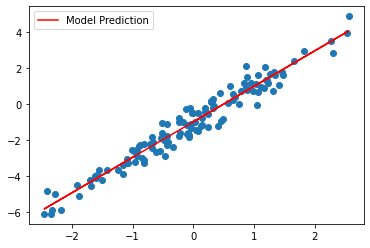

In [7]:
import matplotlib.pyplot as plt

rng = jax.random.PRNGKey(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();

## Taking it further

The strategy described above is how any (jitted) JAX program must handle state. 

Handling parameters manually seems fine if you're dealing with two parameters, but what if it's a neural net with dozens of layers? You might already be getting worried about two things:

1) Are we supposed to initialize them all manually, essentially repeating what we already write in the forward pass definition?

2) Are we supposed to pipe all these things around manually?

The details can be tricky to handle, but there are examples of libraries that take care of this for you. See [JAX Neural Network Libraries](https://github.com/google/jax#neural-network-libraries) for some examples.